Dataset Loaded:
Mission data in columns: [0, 287, 287, 1170, 287, 420, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 1146, 1146, 1146, 1289, 1146, 1146, 1146, 1229, 0, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 0, 338, 0, 307, 0, 0, 0, 89, 776, 0, 0, 0, 865, 1111, 0, 722, 0, 0, 0, 0, 3, 0, 593, 0, 582, 0, 0]
 0.82% Missing -> (3/float64) Is your primary role within your company related to tech/IT?
 0.29% Missing -> (5/object) Do you know the options for mental health care available under your employer-provided coverage?
 0.80% Missing -> (16/float64) Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?
 0.80% Missing -> (17/object) Do you know local or online resources to seek help for a mental health disorder?
 0.80% Missing -> (18/object) If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?
 0.90% Missing -> (19/object) If you have r

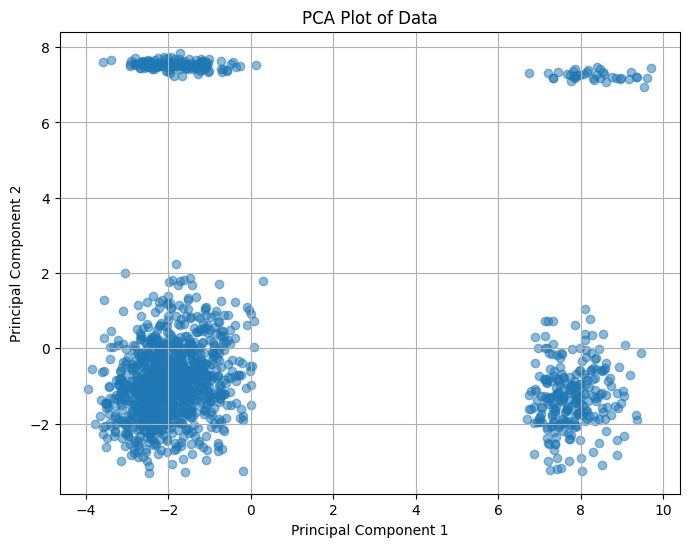

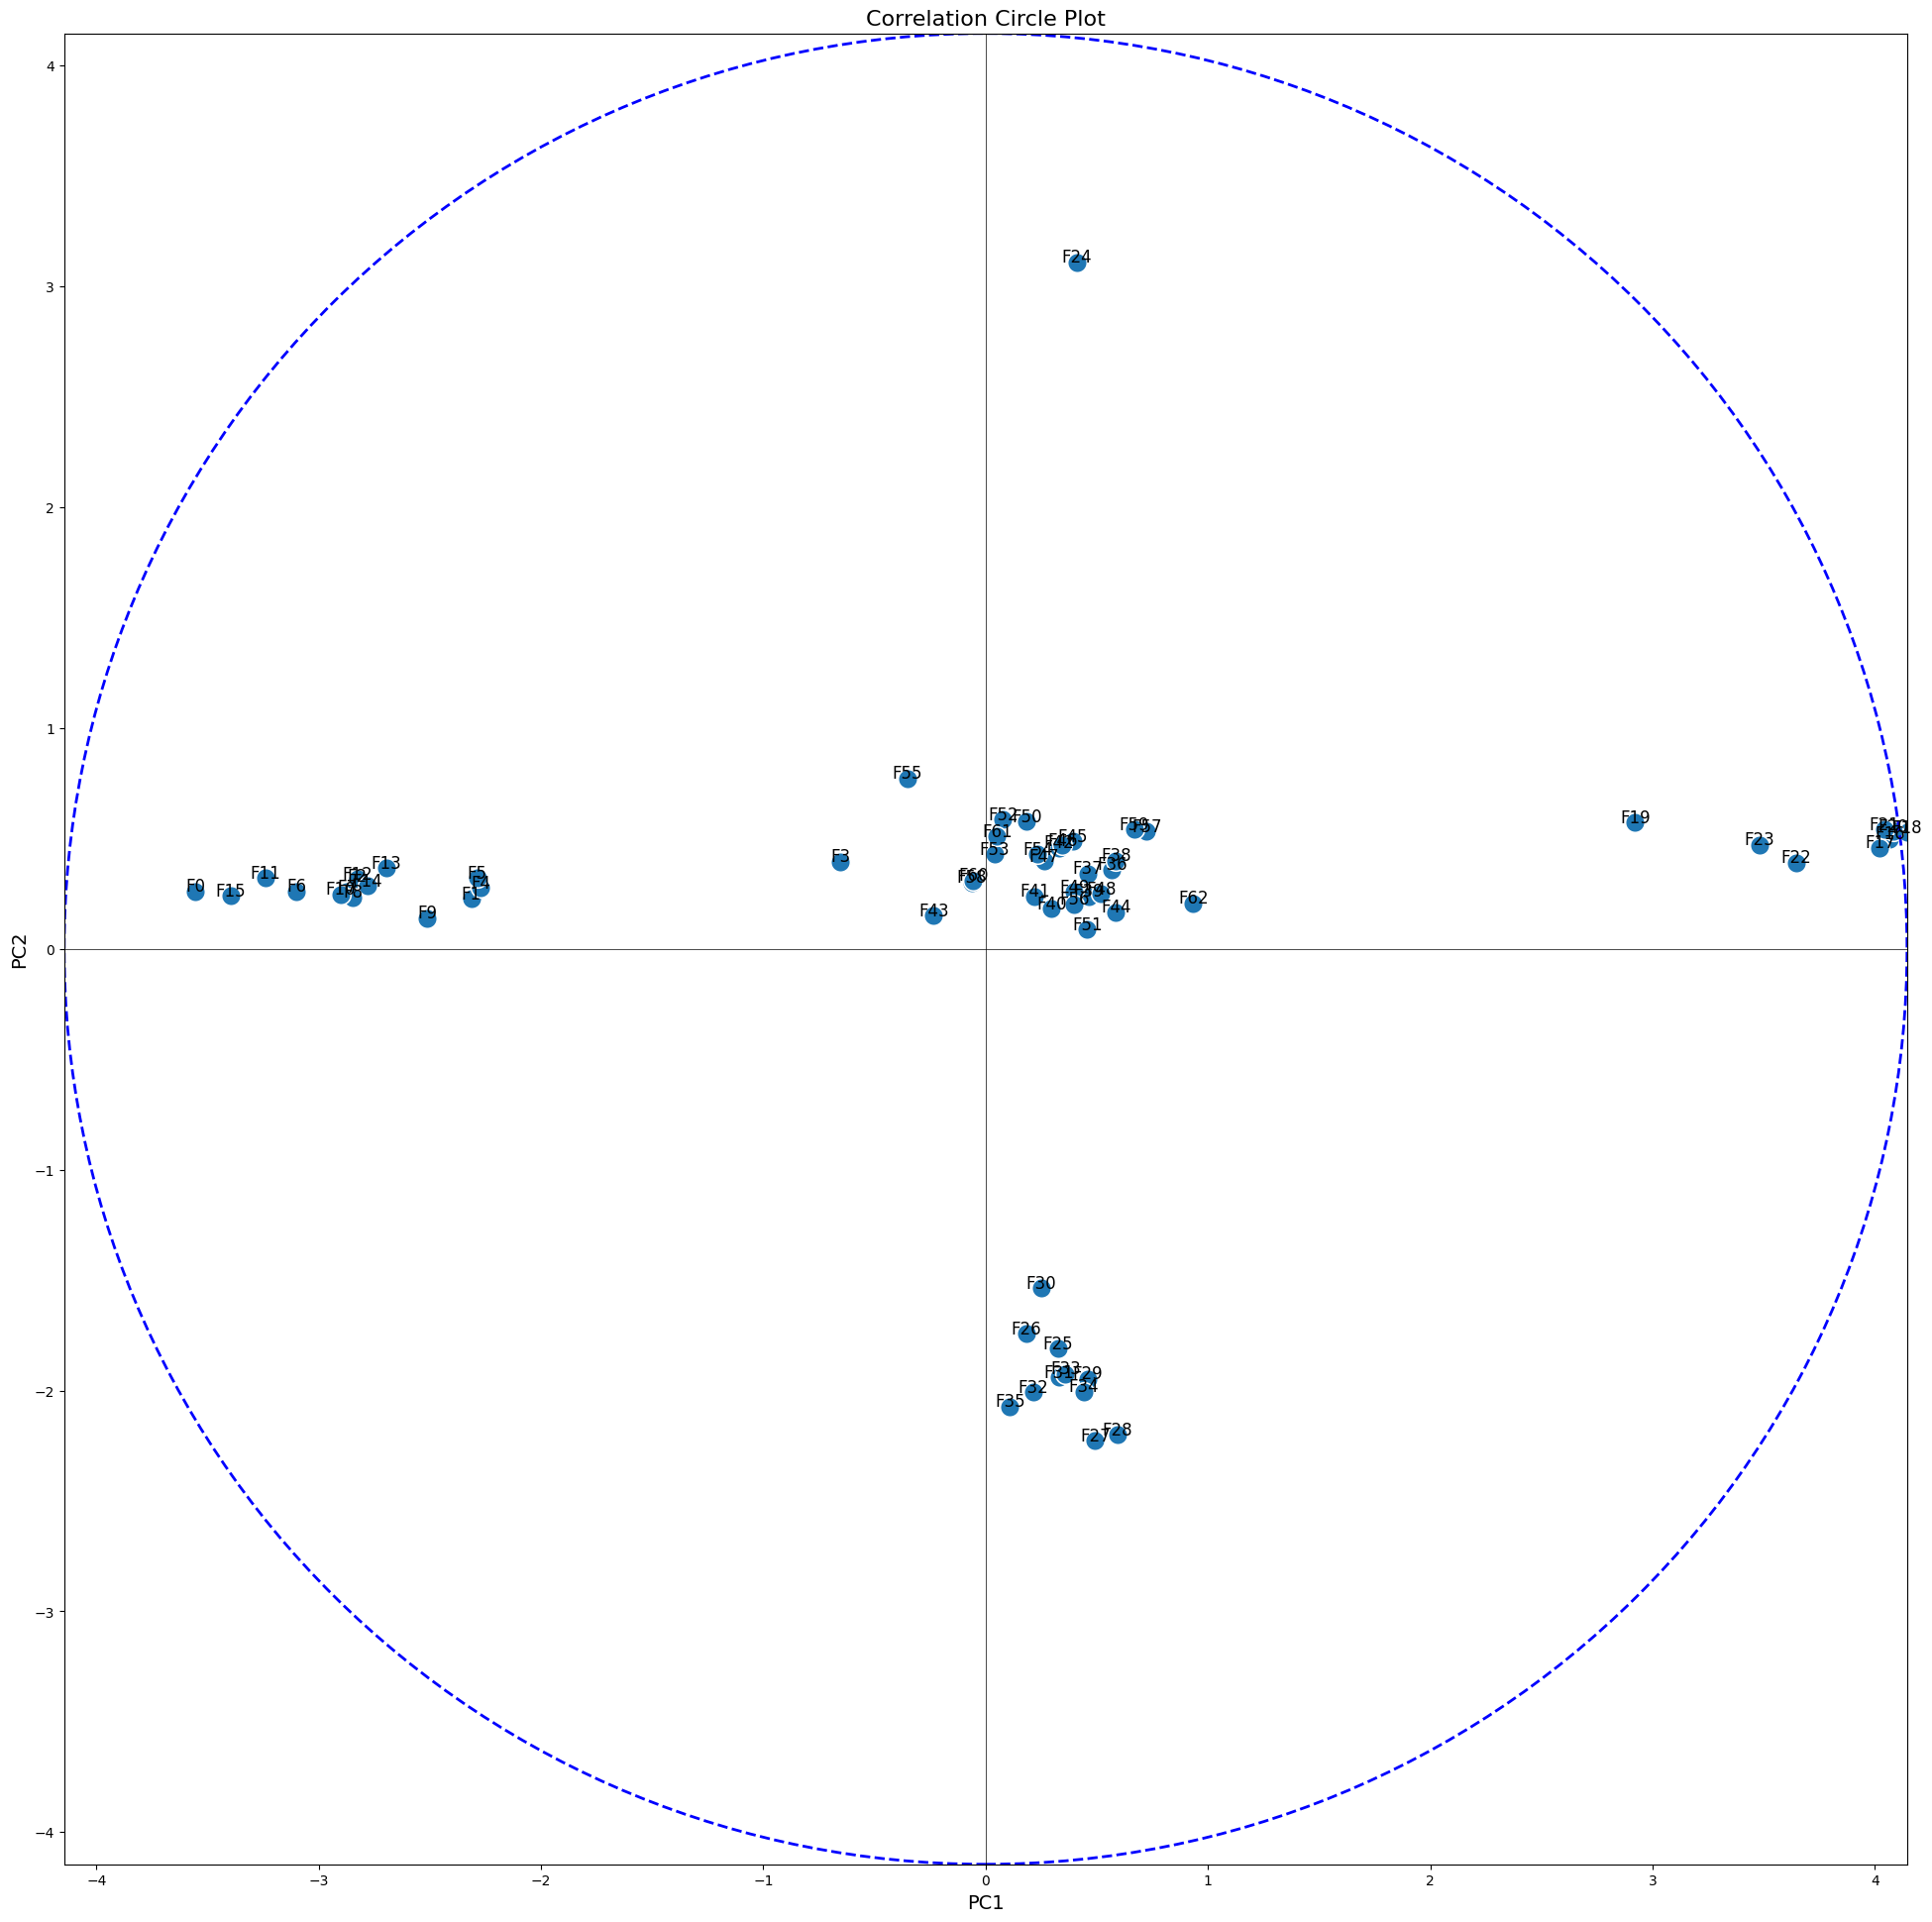

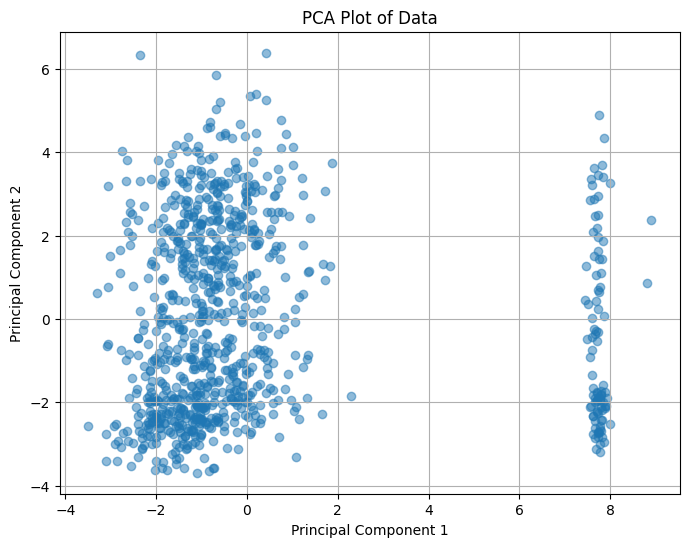

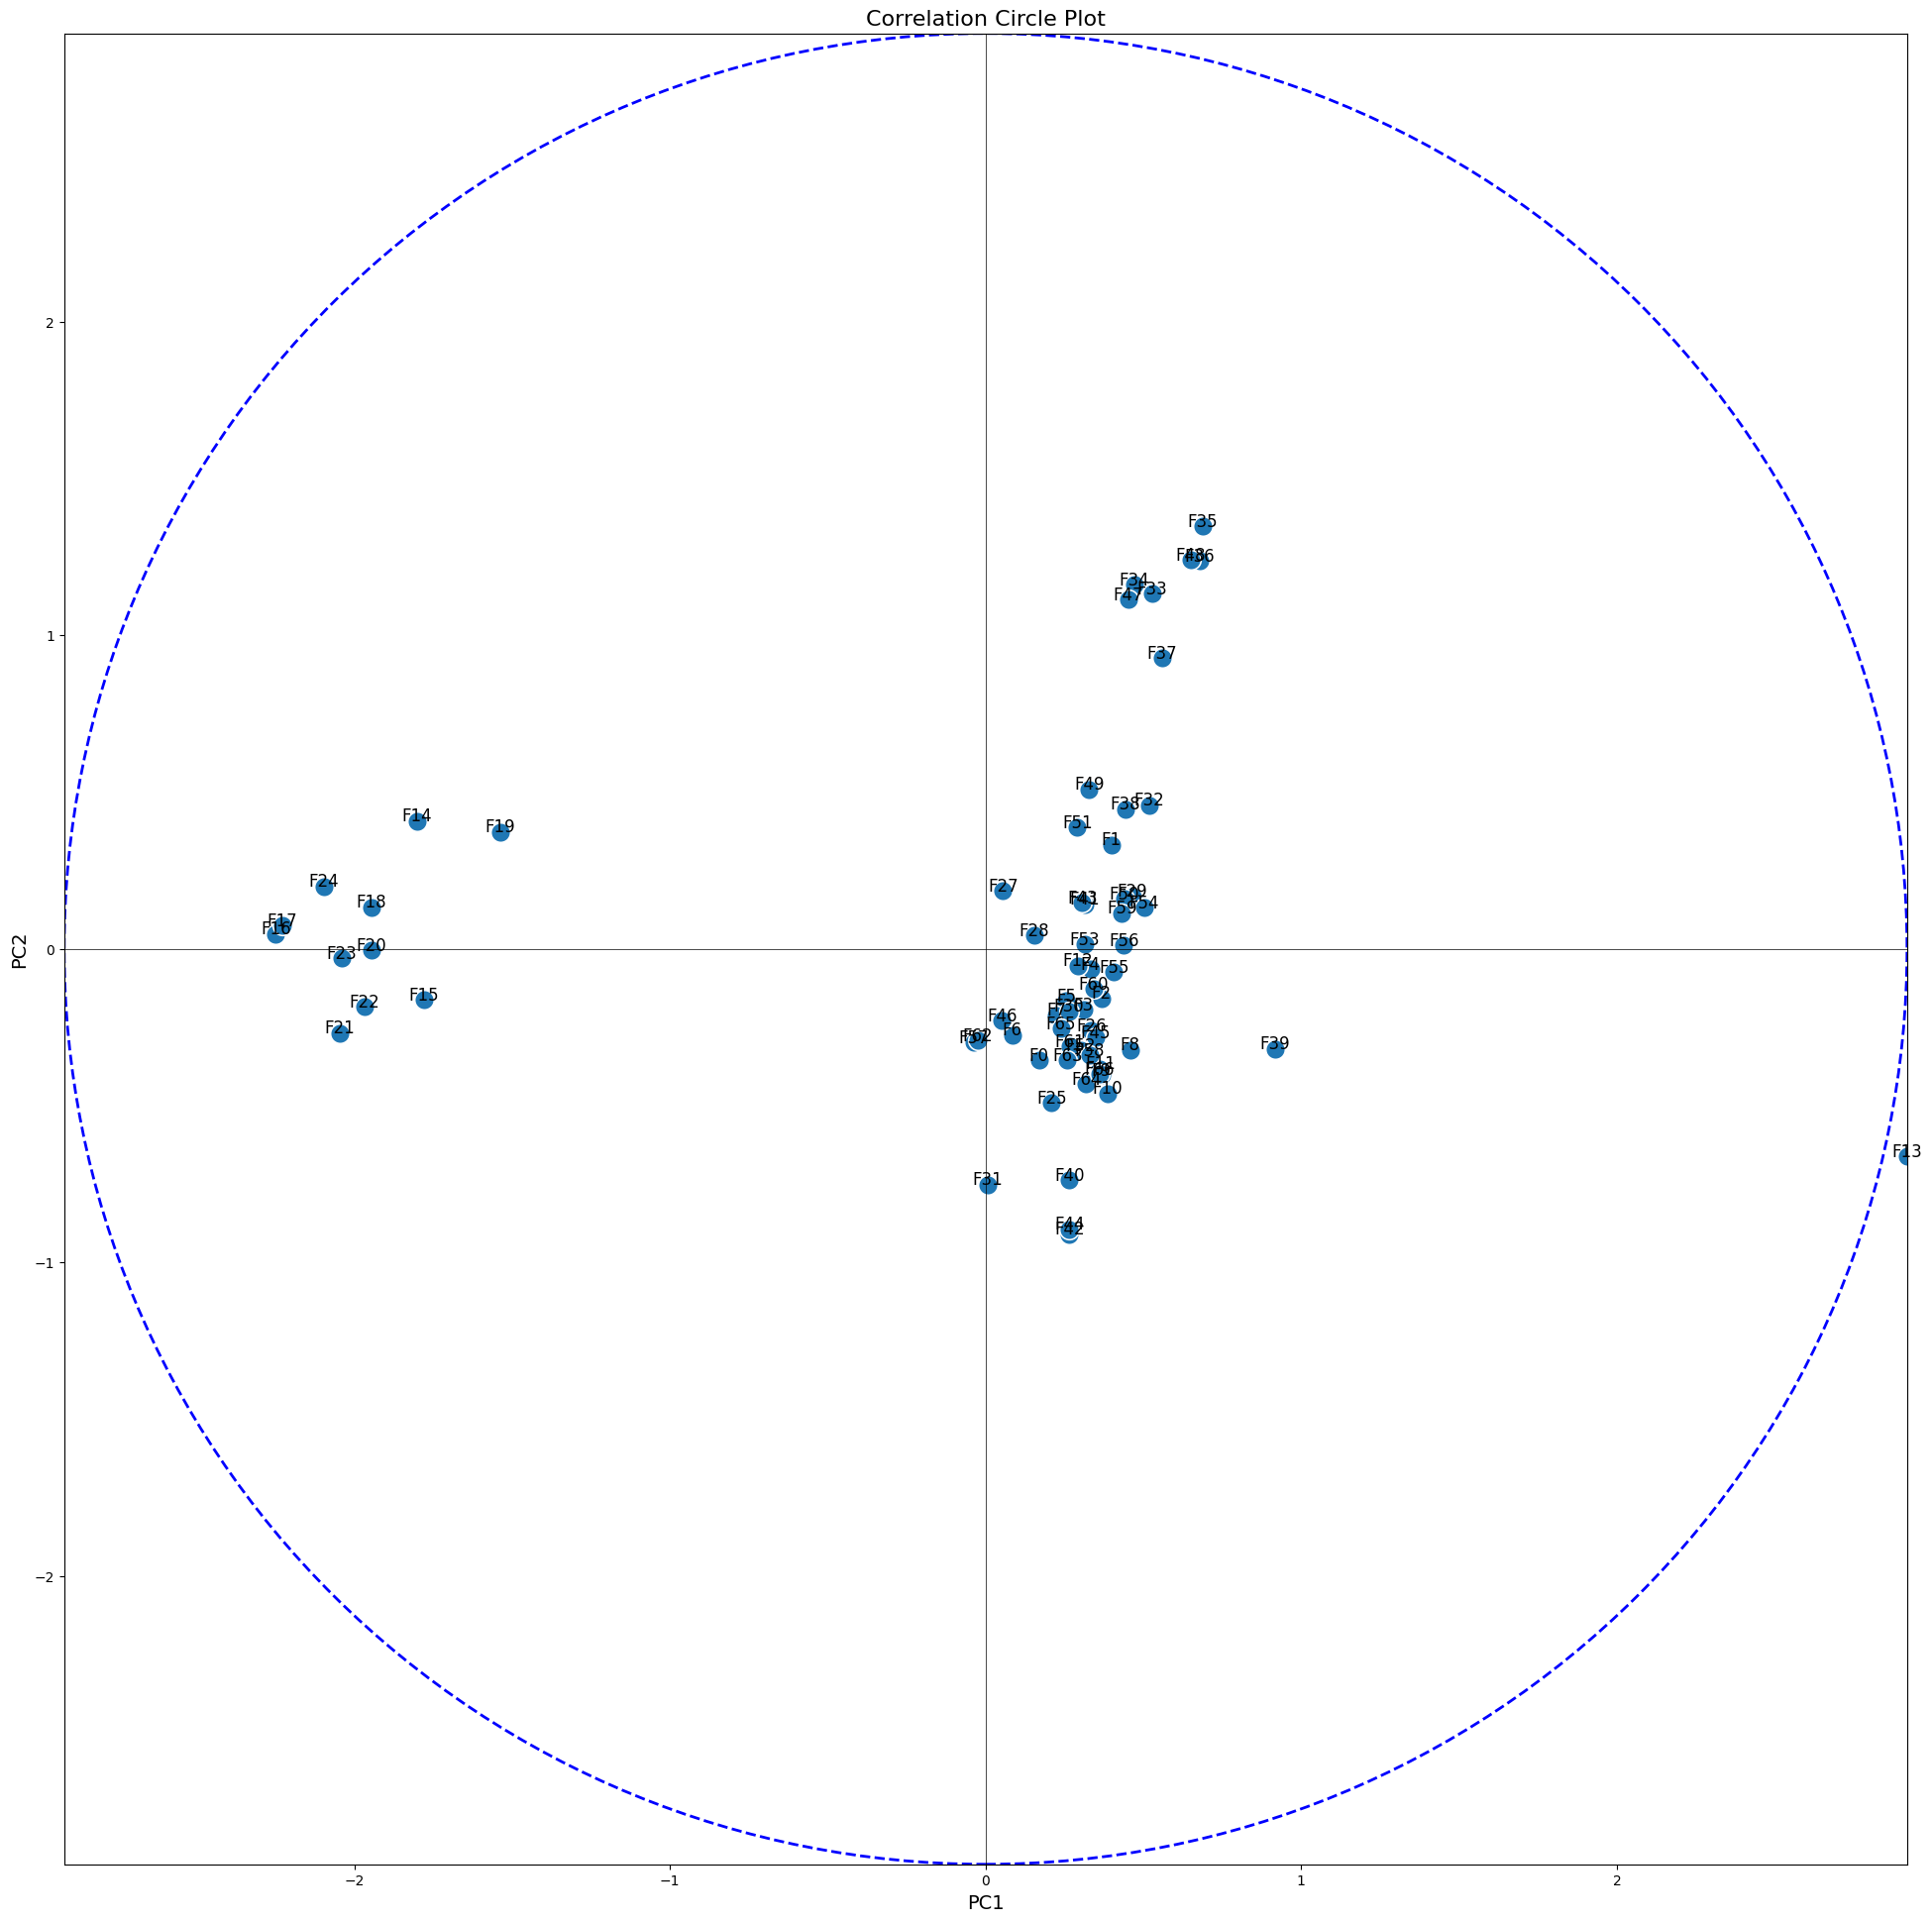

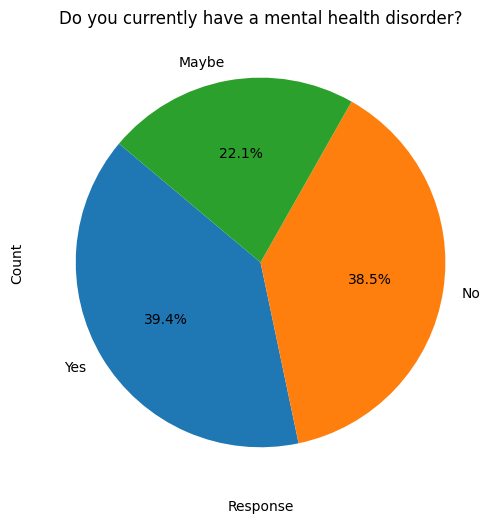

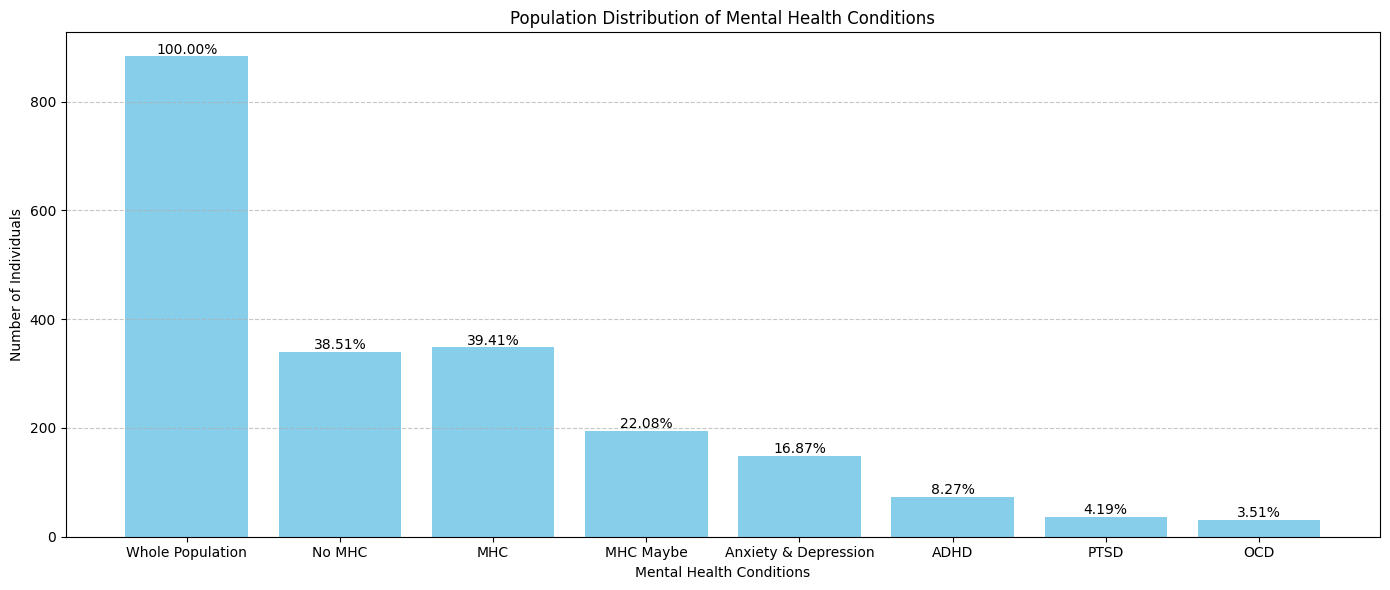

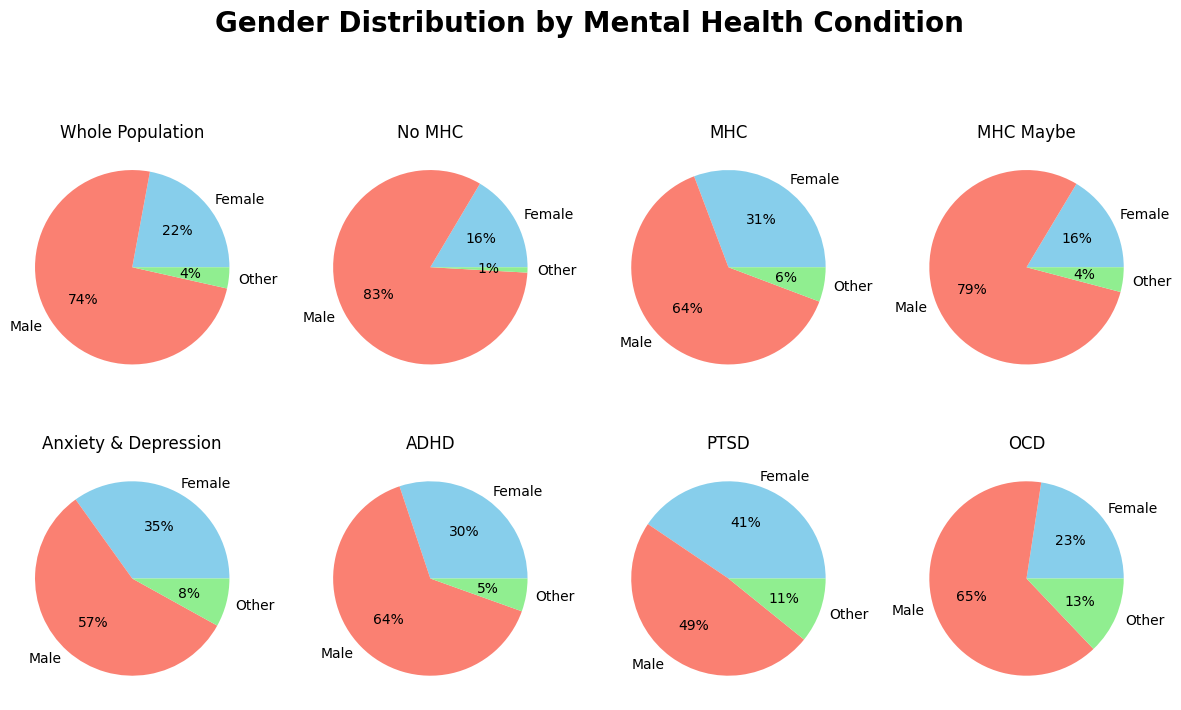

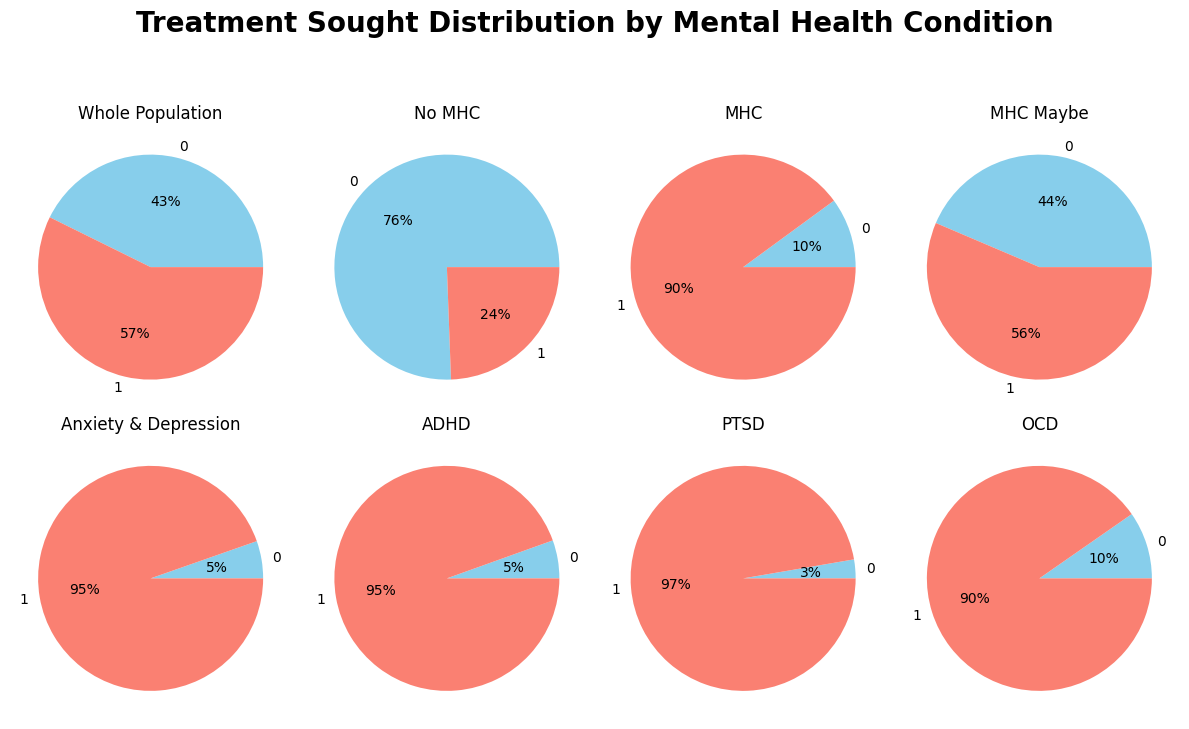

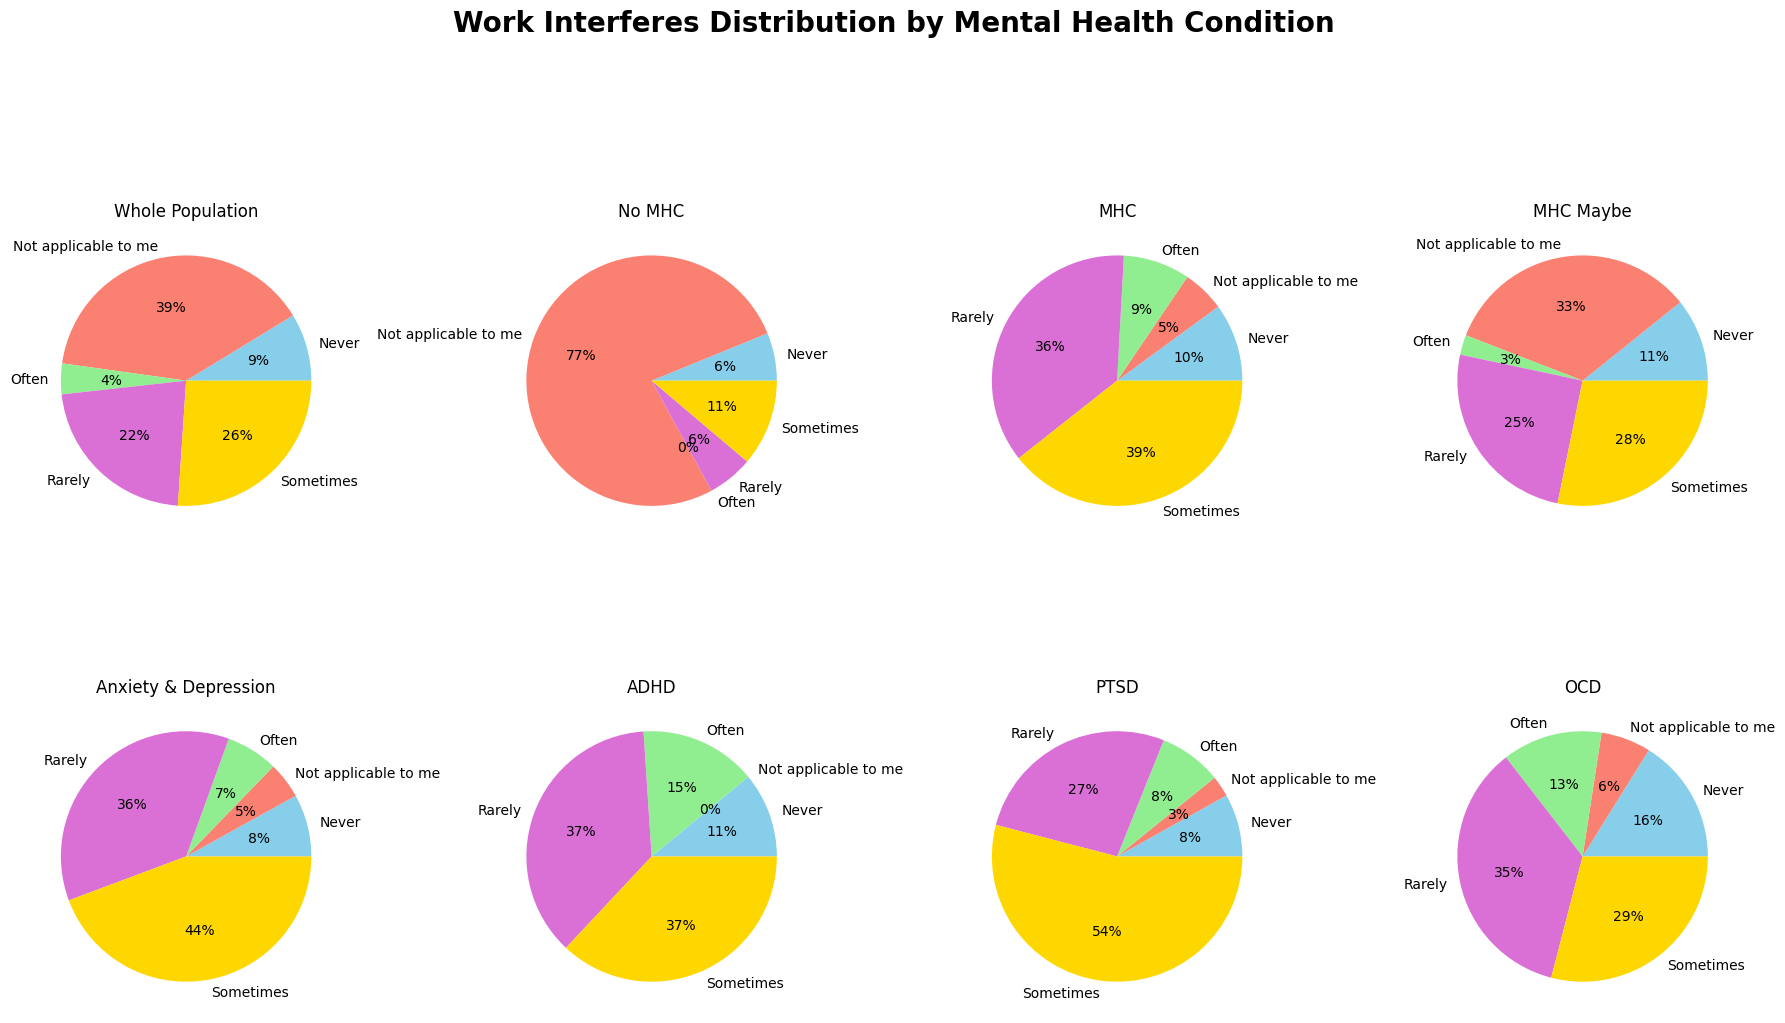

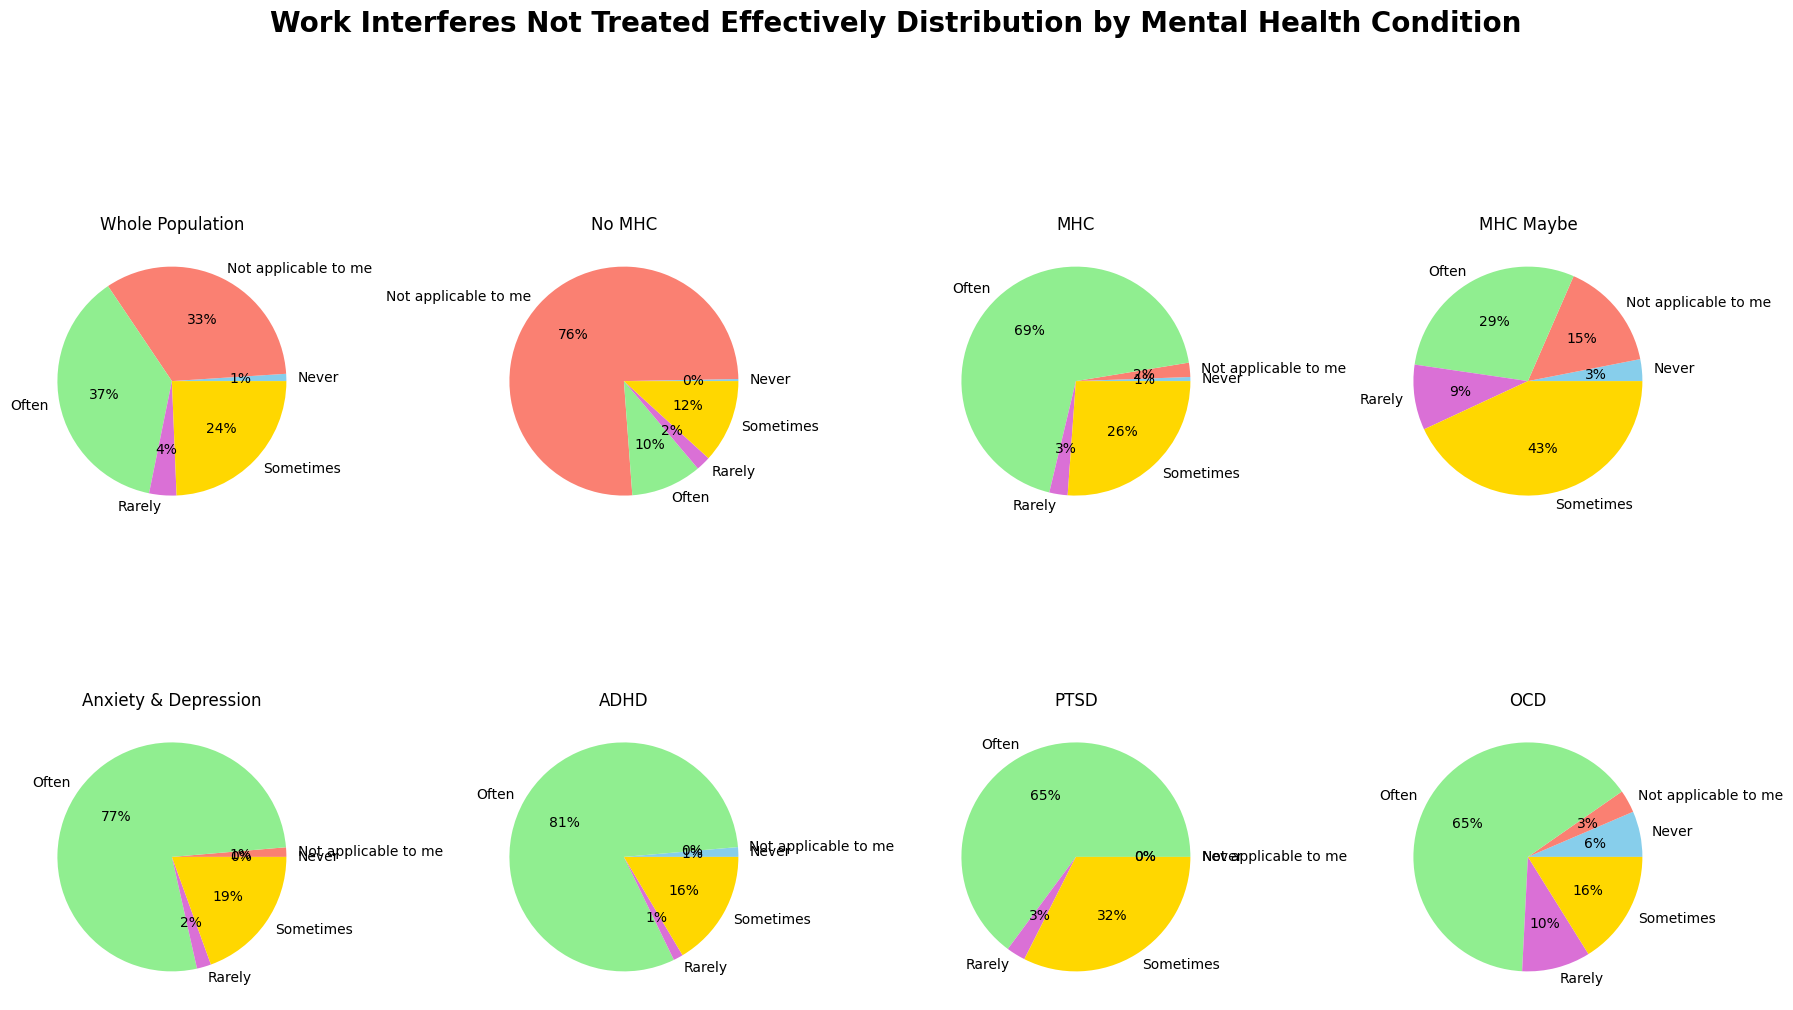

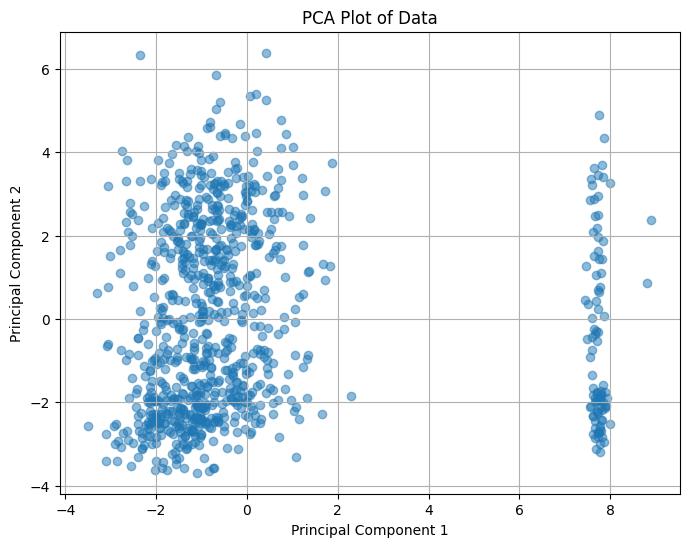

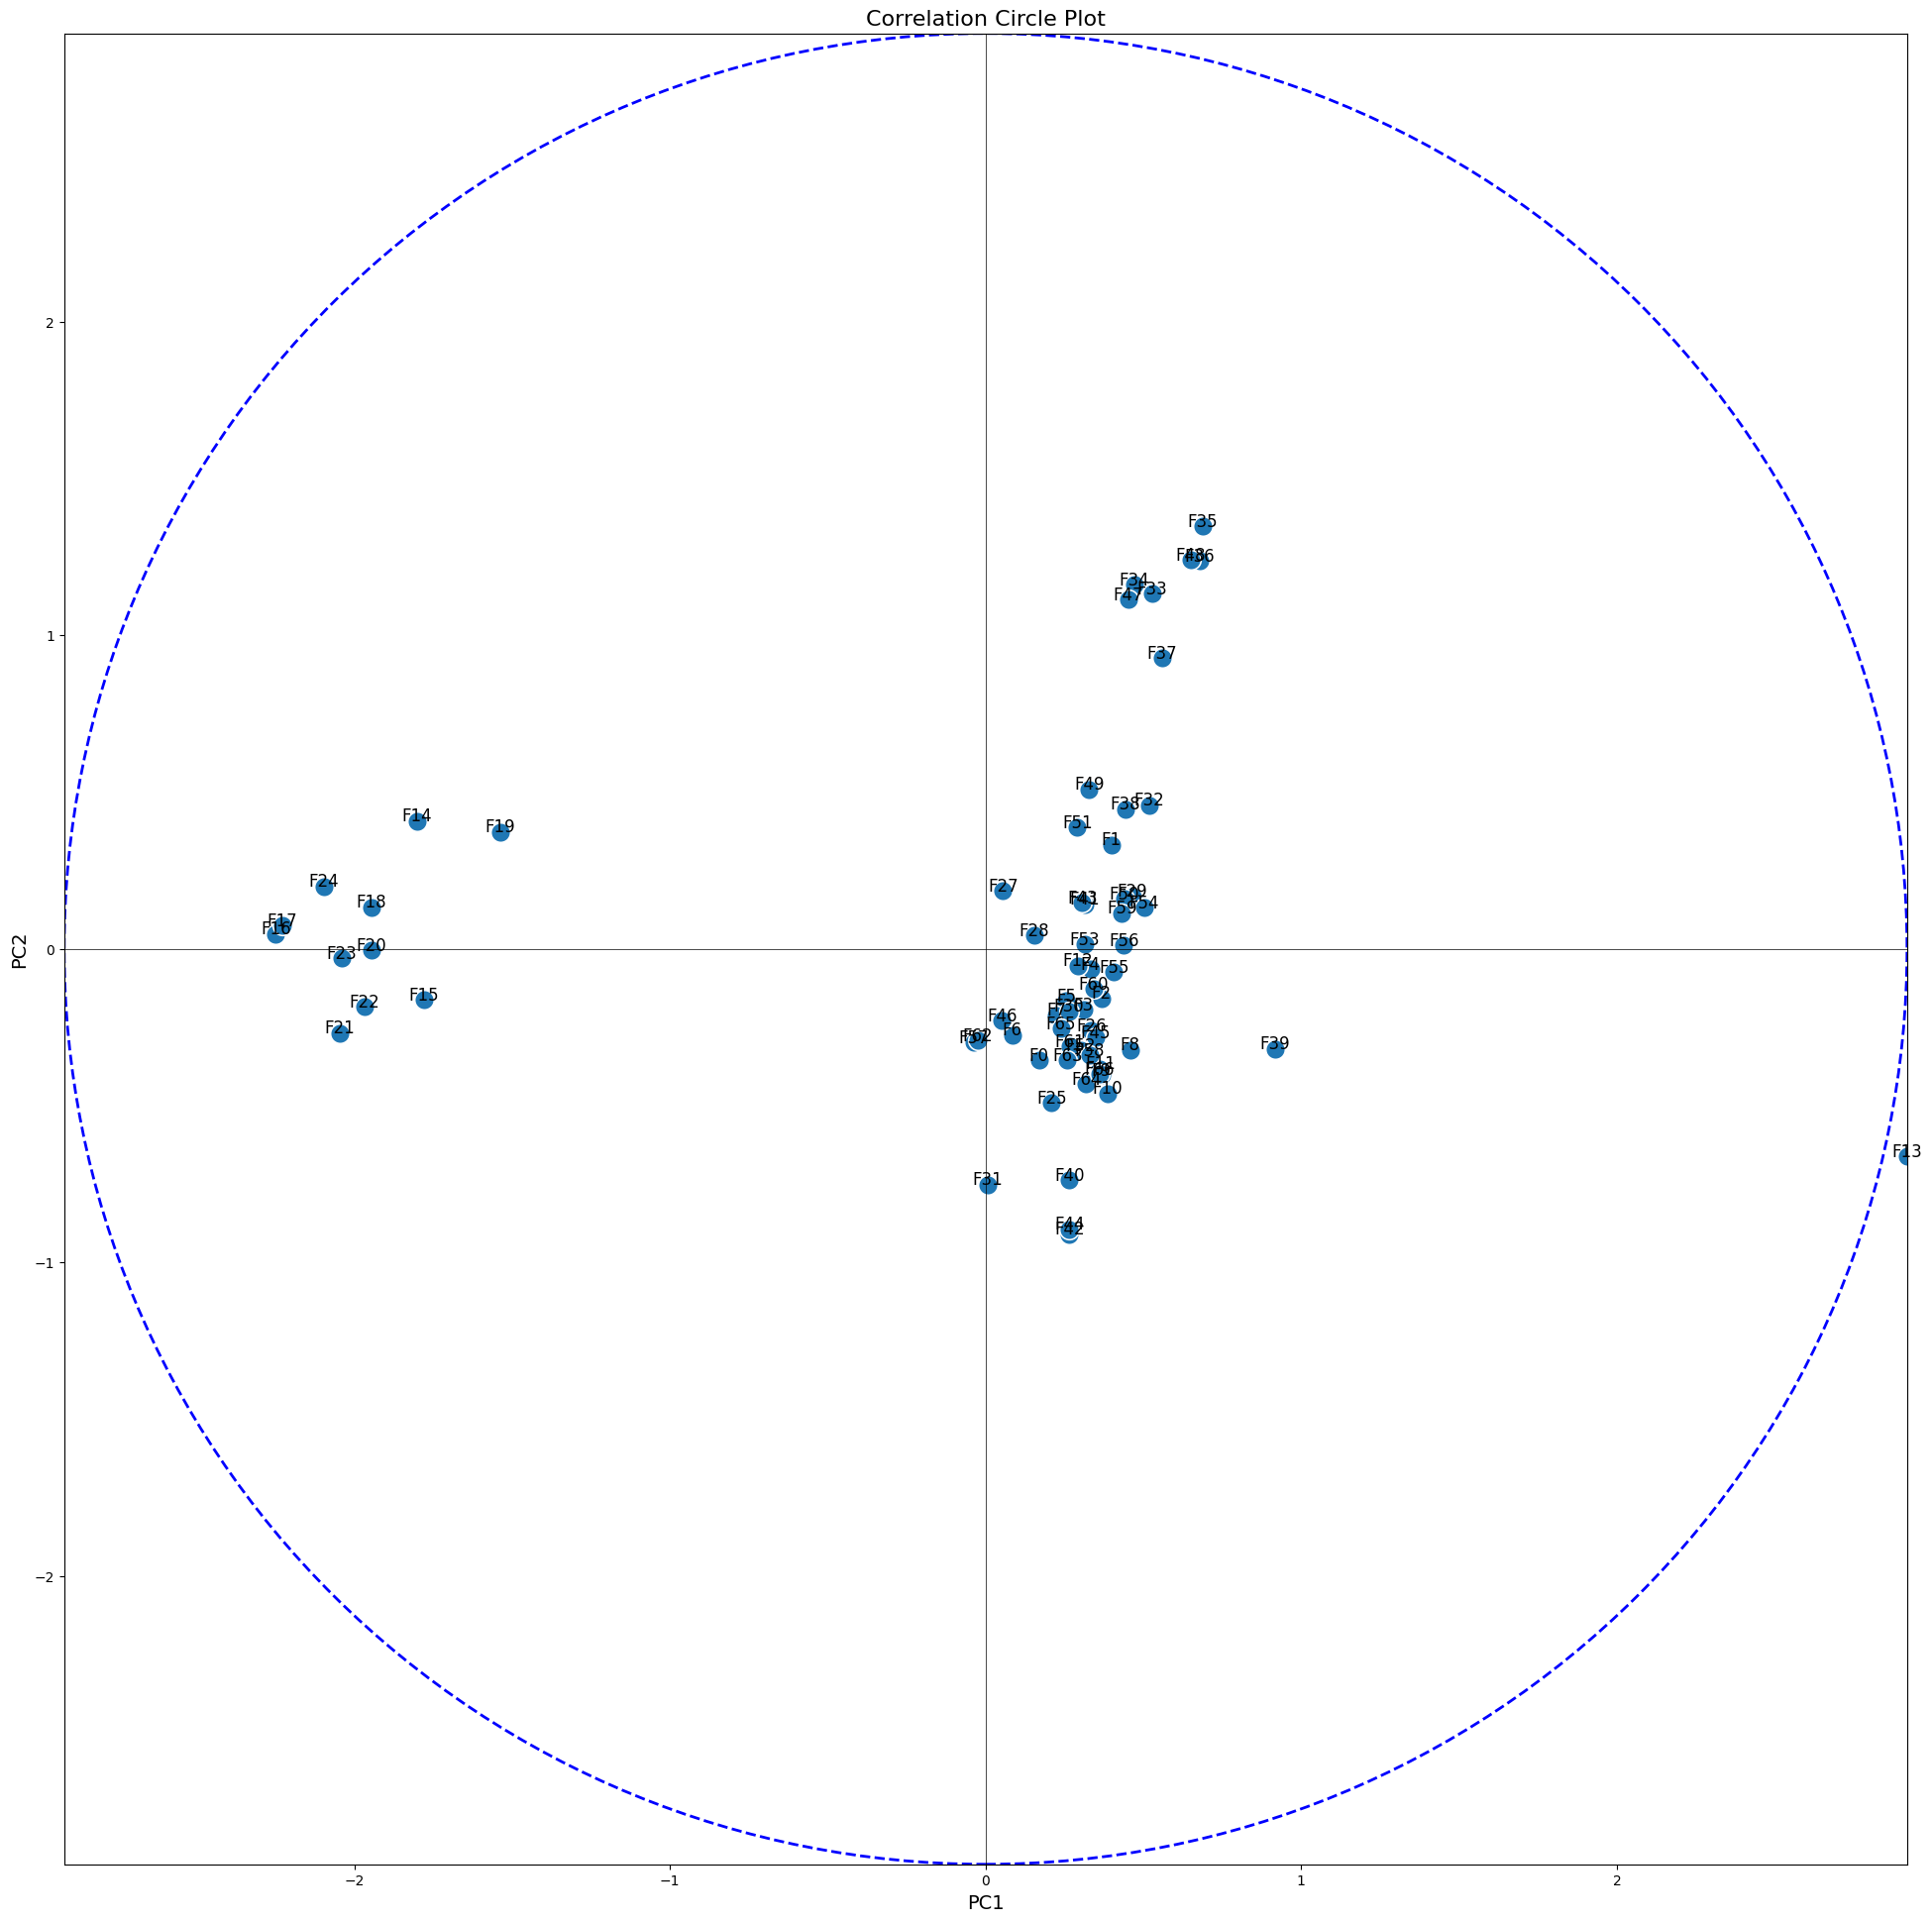

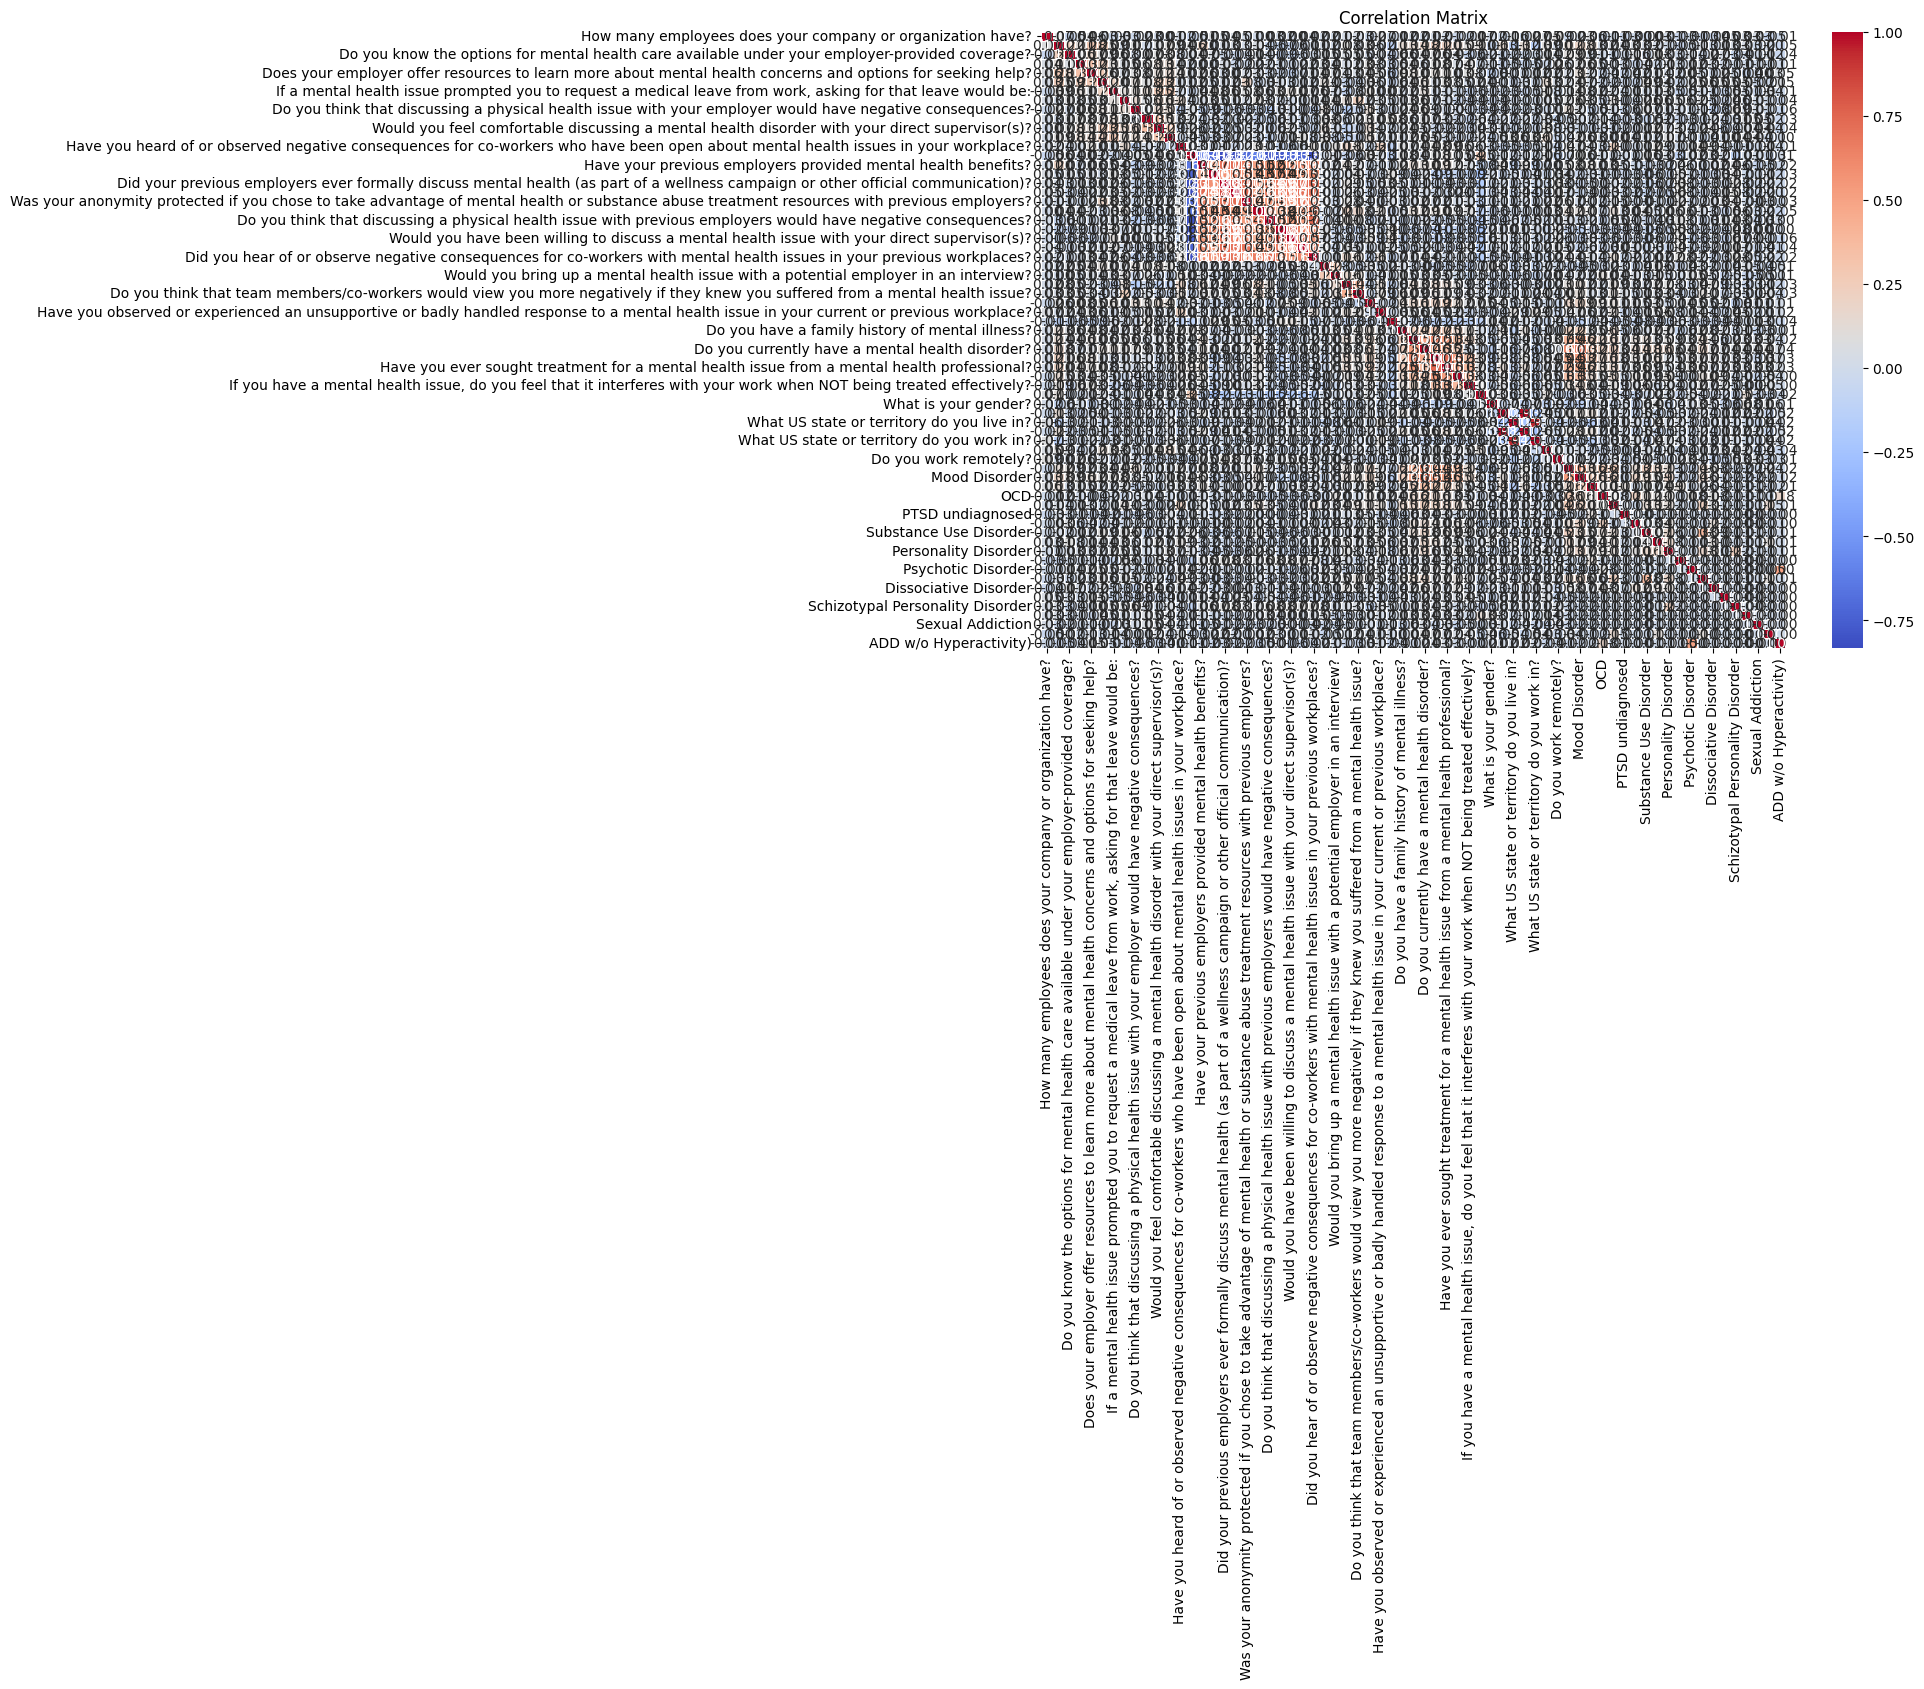

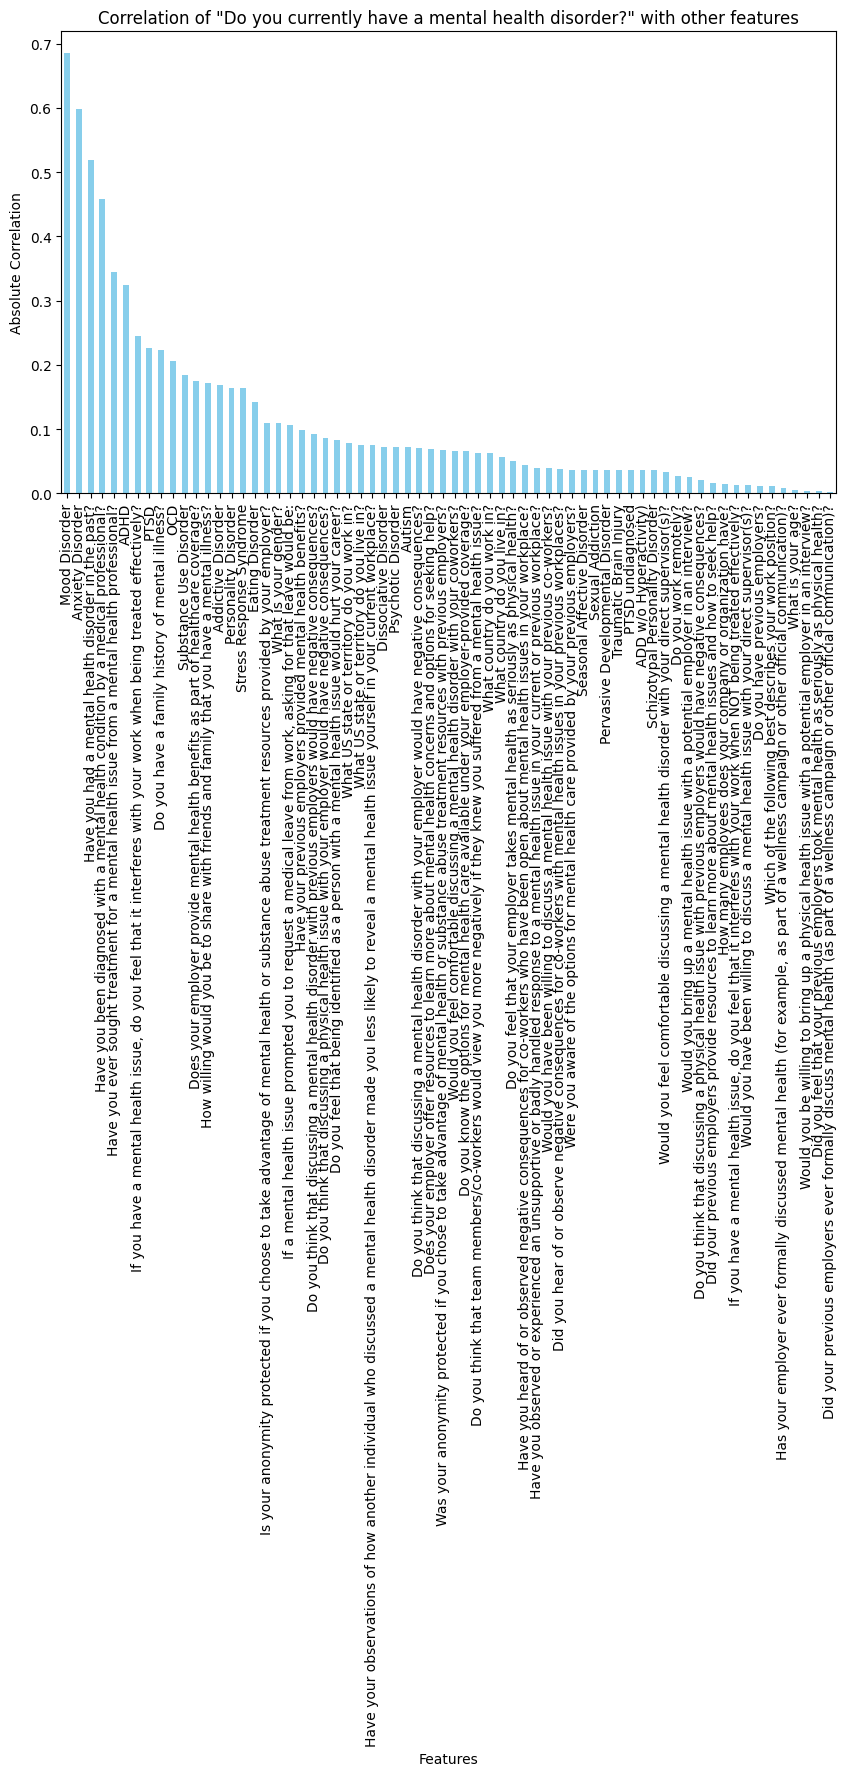

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


# settings
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('future.no_silent_downcasting', True)


def pca_plot_data(df, filename, save_format='png'):
    # Convert categorical variables to numerical
    encoder = LabelEncoder()
    df_encoded = df.apply(encoder.fit_transform)
    # df = pd.get_dummies(df)

    # Perform PCA
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_encoded)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_scaled)

    # Plot PCA
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Plot of Data')
    plt.grid(True)
    plt.savefig(f'{filename}.{save_format}')


def correlation_cycle_plot_data(df, filename, save_format='png'):
    # Convert categorical variables to numerical
    encoder = LabelEncoder()
    df_encoded = df.apply(encoder.fit_transform)
    # df = pd.get_dummies(df)

    corr_matrix = df_encoded.corr()

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(corr_matrix)

    # Create correlation circle plot
    plt.figure(figsize=(24, 24))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], s=200)

    # Plot variable names
    for i in range(len(df.columns)):
        plt.text(pca_result[i, 0], pca_result[i, 1], f"F{str(i)}", fontsize=12, ha='center')

    # Set plot labels and title
    plt.xlabel('PC1', fontsize=14)
    plt.ylabel('PC2', fontsize=14)
    plt.title('Correlation Circle Plot', fontsize=16)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    # plt.grid(True, linestyle='--', alpha=0.7)

    max_value = np.max(pca_result)

    # Add correlation circle
    circle = plt.Circle((0, 0), max_value, color='blue', fill=False, linestyle='--', linewidth=2)
    plt.gca().add_artist(circle)

    # Manually set x and y limits
    plt.xlim(-max_value, max_value)
    plt.ylim(-max_value, max_value)

    plt.savefig(f'{filename}.{save_format}')


# Start ------------------------------------------------------------------------------------------- Loading File
# Define the file path
dt = pd.read_csv("archive/mental-heath-in-tech-2016_20161114.csv")
dt_rows, dt_columns = dt.shape

pca_plot_data(dt, filename="pca_plot_after_loading")
correlation_cycle_plot_data(dt, filename="correlation_cycle_plot_after_loading")

# get survey answers
print(f'Dataset Loaded:')  # \n{dt.head()}

def show_survey_questions():
    for i, column in enumerate(dt.columns):
        print(str(i) + " " + str(column))

mission_data_list = dt.isna().sum().tolist()
print(f"Mission data in columns: {mission_data_list}")

def show_missing_values(dt, more_than_p=0.3):
    dt_rows, _ = dt.shape
    mission_data_list = dt.isna().sum().tolist()
    more_than_n = dt_rows*more_than_p
    for i, n in enumerate(mission_data_list):
        if mission_data_list[i] >= more_than_n:
            print(f'{n / dt_rows: .2f}% Missing -> ({i}/{dt[dt.columns[i]].dtype}) {dt.columns[i]}')

show_missing_values(dt, more_than_p=0.26)
# Finish ------------------------------------------------------------------------------------------- Loading File

# Start ------------------------------------------------------------------------------------------- Dataset Preprocessing
# Cleaning Age Feature
filtered_values = dt[(dt['What is your age?'] > 99) | (dt['What is your age?'] < 18)]
print(f'Found in "What is your age?" {len(filtered_values)} incorrect data ')
filtered_indices = filtered_values.index
valid_age_indices = dt.index.difference(filtered_indices)
mean_age = dt.loc[valid_age_indices, 'What is your age?'].mean()
dt.loc[filtered_indices, 'What is your age?'] = int(mean_age)
print(f"Updated the {filtered_indices} with the int mean of others({int(mean_age)})")

# Cleaning Gender Feature
unique_values_gender_before = dt['What is your gender?'].unique()
print(f"The gender feature have {len(unique_values_gender_before)} unique values")
def clean_gender(gender):
    gender = str(gender).strip().lower()
    if gender in ['male', 'm', 'man', 'cis male', 'malr', 'mail', 'male.', 'sex is male', 'm|', 'cis male', 'cis man', 'male (cis)', 'dude']:
        return 'Male'
    elif gender in ['female', 'f', 'woman', 'cis female', 'cis-woman', 'cisgender female', 'female assigned at birth', 'fem', 'female.', 'female ']:
        return 'Female'
    else:
        return 'Other'

dt['What is your gender?'] = dt['What is your gender?'].apply(clean_gender)
print(f"After processing gender feature have 3 unique values: {dt['What is your gender?'].unique()}")


# Cleaning not relevant data
def show_data_to_be_removed_relevant_info(feature_key, expected_value):
    dataset_len = len(dt[feature_key])
    dataset_interested_in_len = len(dt.loc[(dt[feature_key] == expected_value)])
    print(f'Feature "{feature_key}" have unique values: {dt[feature_key].unique()}')
    print(f'Interested dat values is "{expected_value}"')
    print(f'The drop in percentage is {1 - dataset_interested_in_len/dataset_len: .2f}%')

for feature_key, expected_value in [('Are you self-employed?', 0), ('Is your employer primarily a tech company/organization?', 1)]:
    show_data_to_be_removed_relevant_info(feature_key, expected_value)

# Select only participants working for a company
dt = dt.loc[(dt['Are you self-employed?'] == 0)]
dt = dt.reset_index(drop=True)

# Select only participants working for a tech company
dt = dt.loc[(dt['Is your employer primarily a tech company/organization?'] == 1)]
dt = dt.reset_index(drop=True)



#Create separate columns for presence of each MHC for easier filter
# TODO: add other descriptions analysis for example ('If so, what condition(s) were you diagnosed with?')
details_about_condition_feature_key = 'If yes, what condition(s) have you been diagnosed with?'
print(dt[details_about_condition_feature_key].value_counts())
conditions = {
    'Anxiety Disorder': 'Anxiety Disorder',
    'Mood Disorder': 'Mood Disorder',
    'ADHD': 'Attention',
    'OCD': 'Compulsive',
    'PTSD': 'Post',
    'PTSD undiagnosed': 'PTSD \(undiagnosed\)',
    'Eating Disorder': 'Eating',
    'Substance Use Disorder': 'Substance',
    'Stress Response Syndrome': 'Stress Response',
    'Personality Disorder': 'Personality Disorder',
    'Pervasive Developmental Disorder': 'Pervasive',
    'Psychotic Disorder': 'Psychotic',
    'Addictive Disorder': 'Addictive Disorder',
    'Dissociative Disorder': 'Dissociative',
    'Seasonal Affective Disorder': 'Seasonal',
    'Schizotypal Personality Disorder': 'Schizotypal',
    'Traumatic Brain Injury': 'Brain',
    'Sexual Addiction': 'Sexual',
    'Autism': 'Autism',
    'ADD w/o Hyperactivity)': 'ADD \(w/o Hyperactivity\)'
}

for condition, substring in conditions.items():
    dt[condition] = dt[details_about_condition_feature_key].str.contains(substring)
    # dt[condition].fillna(False, inplace=True)
    dt[condition] = dt[condition].fillna(False).infer_objects(copy=False)

# If users was not living in USA
columns_to_fill_none_str = [
    'What US state or territory do you live in?',
    'What US state or territory do you work in?'
]
dt[columns_to_fill_none_str] = dt[columns_to_fill_none_str].fillna("None")



# To remove columns wehre user was writing own text(this can be done by checking the unicue values)
def high_uniqueness_features(df, threshold=10):
    high_uniqueness_features = []
    for column in df.columns:
        unique_values = df[column].nunique()
        if unique_values > threshold:
            high_uniqueness_features.append(column)
    return high_uniqueness_features

# Check for features with high nuniques
high_uniqueness_feats = high_uniqueness_features(dt, threshold=10)
print("Features with more than 10 unique values:", high_uniqueness_feats)
# Delete features that user was writing by himself
own_user_type_description_feature_keys = [
    'Why or why not?',
    'Why or why not?.1',
    'If yes, what condition(s) have you been diagnosed with?',
    'If maybe, what condition(s) do you believe you have?',
    'If so, what condition(s) were you diagnosed with?'
]
dt.drop(columns=own_user_type_description_feature_keys, inplace=True)


# print(dt['Are you self-employed?'].value_counts())
# print(dt['How many employees does your company or organization have?'].value_counts())
# print(dt['Is your primary role within your company related to tech/IT?'].value_counts())
# print(dt['Is your primary role within your company related to tech/IT?'].nunique())
features_with_no_variance = dt.columns[dt.nunique() <= 1]
dt.drop(columns=features_with_no_variance, inplace=True)


pca_plot_data(dt, filename="pca_plot_after_data_processing")
correlation_cycle_plot_data(dt, filename="correlation_cycle_plot_after_data_processing")
# Finish ------------------------------------------------------------------------------------------- Dataset Preprocessing


# Start ------------------------------------------------------------------------------------------- Dataset Visualizing

currently_have_mental_health_disorder_feature_counts = dt['Do you currently have a mental health disorder?'].value_counts()
print(currently_have_mental_health_disorder_feature_counts)
# Plot
plt.figure(figsize=(6, 6))
plt.pie(
    currently_have_mental_health_disorder_feature_counts.values.tolist(),
    labels=currently_have_mental_health_disorder_feature_counts.index.tolist(),
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Do you currently have a mental health disorder?')
plt.xlabel('Response')
plt.ylabel('Count')
plt.savefig('mental_health_disorder_plot.png')


# Splitting to smaller datasets
# dt_no_MHD = dt.loc[pd.isna(dt[details_about_condition_feature_key])]
dt_no_MHD = dt.loc[(dt['Do you currently have a mental health disorder?'] == "No")]
dt_yes_MHD = dt.loc[(dt['Do you currently have a mental health disorder?'] == "Yes")]
dt_maybe_MHD = dt.loc[(dt['Do you currently have a mental health disorder?'] == "Maybe")]
dt_anx_dep = dt.loc[(dt['Anxiety Disorder'] == 1) & (dt['Mood Disorder'] == 1)]
dt_adhd = dt.loc[(dt['ADHD'] == 1)]
dt_ocd = dt.loc[(dt['OCD'] == 1)]
dt_ptsd = dt.loc[(dt['PTSD'] == 1)]

#Display population size of each group
total_population_len = len(dt)
dt_group = [
    (dt, 'Whole Population'),
    (dt_no_MHD, 'No MHC'),
    (dt_yes_MHD, 'MHC'),
    (dt_maybe_MHD, 'MHC Maybe'),
    (dt_anx_dep, 'Anxiety & Depression'),
    (dt_adhd, 'ADHD'),
    (dt_ptsd, 'PTSD'),
    (dt_ocd, 'OCD')
]
dt_group_labels = [label for _, label in dt_group]
dt_group_datasets = [data for data, _ in dt_group]
dt_group_datasets_counts = [len(data) for data in dt_group_datasets]
percentages = [(len(data) / total_population_len) * 100 for data in dt_group_datasets]
dt_MHD_count = pd.DataFrame({
    'Population': dt_group_labels,
    'Count': dt_group_datasets_counts,
    'Percentage': percentages
})

# Plot dt_MHD_count DataFrame
plt.figure(figsize=(14, 6))
bars = plt.bar(dt_group_labels, dt_group_datasets_counts, color='skyblue')
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{percentage:.2f}%', ha='center', color='black')
plt.title('Population Distribution of Mental Health Conditions')
plt.xlabel('Mental Health Conditions')
plt.ylabel('Number of Individuals')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('population_count_plot.png')


def multiply_tuple_scalar(tuple_to_multiply, scalar):
    return tuple(value * scalar for value in tuple_to_multiply)

# Gender statistics
def create_sorted_dt(dt, label, base_label):
    counts = dt[base_label].value_counts().sort_index().reset_index()
    counts.columns = [base_label, label]
    return counts

dt_gender = None
for data, label in dt_group:
    counts_MHC = create_sorted_dt(data, f'What is your gender? ({label})', base_label='What is your gender?')
    dt_gender = dt_gender.merge(counts_MHC, on='What is your gender?', how='left') if dt_gender is not None else counts_MHC

# Plotting
def plot_dt_group_statistics(dt_statistics, statistics_feature, title, filename, save_format='png', figsize=1):
    fig, axs = plt.subplots(2, 4, figsize=multiply_tuple_scalar((12, 8), figsize))
    axs = axs.flatten()  # Flatten the subplot array for easier iteration

    colors = ['skyblue', 'salmon', 'lightgreen', 'orchid', 'gold']
    # MHC_labels = [whole_population] + MHCs
    MHC_columns = dt_statistics.columns.to_list()[1:]
    # Plot each MHC distribution
    for ax, label, column in zip(axs, dt_group_labels, MHC_columns):
        ax.pie(dt_statistics[column], labels=dt_statistics[statistics_feature], colors=colors, autopct='%.0f%%')
        ax.set_title(label, fontsize=12)

    # Adjust layout and add title
    plt.suptitle(title, weight='bold', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust subplot layout to make space for title

    plt.savefig(f'{filename}.{save_format}')

plot_dt_group_statistics(
    dt_statistics=dt_gender,
    statistics_feature='What is your gender?',
    title='Gender Distribution by Mental Health Condition',
    filename="population_count_by_gender_plot"
)


# Age statistics
age_stats = {}
for data, label in dt_group:
    age_stats[label] = data['What is your age?'].describe()
dt_age_stats = pd.DataFrame(age_stats).reset_index()
dt_age_stats.columns = ['Statistic'] + dt_group_labels
print(dt_age_stats)


# sought treatment statistics
sought_treatment_feature = 'Have you ever sought treatment for a mental health issue from a mental health professional?'
dt_treated_sought_counts = None
for data, label in dt_group:
    counts_MHC = create_sorted_dt(data, label, base_label=sought_treatment_feature)
    dt_treated_sought_counts = dt_treated_sought_counts.merge(counts_MHC, on=sought_treatment_feature, how='left') if dt_treated_sought_counts is not None else counts_MHC
dt_treated_sought_counts = dt_treated_sought_counts.fillna(0)
# Plotting sought treatment statistics
plot_dt_group_statistics(
    dt_statistics=dt_treated_sought_counts,
    statistics_feature=sought_treatment_feature,
    title='Treatment Sought Distribution by Mental Health Condition',
    filename="population_count_by_treatment_sought_plot"
)




# work interfere statistics
mhc_interferes_with_work_feature = 'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?'
dt_mhc_interferes_with_work_feature_counts = None
for data, label in dt_group:
    counts_MHC = create_sorted_dt(data, label, base_label=mhc_interferes_with_work_feature)
    dt_mhc_interferes_with_work_feature_counts = dt_mhc_interferes_with_work_feature_counts.merge(counts_MHC, on=mhc_interferes_with_work_feature, how='left') if dt_mhc_interferes_with_work_feature_counts is not None else counts_MHC
dt_mhc_interferes_with_work_feature_counts = dt_mhc_interferes_with_work_feature_counts.fillna(0)
# Plotting work interfere statistics
plot_dt_group_statistics(
    dt_statistics=dt_mhc_interferes_with_work_feature_counts,
    statistics_feature=mhc_interferes_with_work_feature,
    title='Work Interferes Distribution by Mental Health Condition',
    filename="population_count_by_mhc_work_interferes_plot",
    figsize=1.5
)



# work interfere not treated effectively statistics
work_interfere_not_treated_effectively_feature = 'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?'
work_interfere_not_treated_effectively_feature_counts = None
for data, label in dt_group:
    counts_MHC = create_sorted_dt(data, label, base_label=work_interfere_not_treated_effectively_feature)
    work_interfere_not_treated_effectively_feature_counts = work_interfere_not_treated_effectively_feature_counts.merge(counts_MHC, on=work_interfere_not_treated_effectively_feature, how='left') if work_interfere_not_treated_effectively_feature_counts is not None else counts_MHC
work_interfere_not_treated_effectively_feature_counts = work_interfere_not_treated_effectively_feature_counts.fillna(0)
# Plotting work interfere statistics
plot_dt_group_statistics(
    dt_statistics=work_interfere_not_treated_effectively_feature_counts,
    statistics_feature=work_interfere_not_treated_effectively_feature,
    title='Work Interferes Not Treated Effectively Distribution by Mental Health Condition',
    filename="population_count_by_work_interfere_not_treated_effectively_plot",
    figsize=1.5
)




# import seaborn as sns
# import matplotlib.pyplot as plt
# # Loop through each column and plot value counts
# for col in dt.columns:
#     plt.figure(figsize=(8, 6))
#     sns.countplot(data=dt, x=col)
#     plt.title(f'Value Counts of {col}')
#     plt.xticks(rotation=45)
#     plt.show()

dt.to_csv("my_dt.csv", index=False)

print(dt.shape)
print(dt['Do you know the options for mental health care available under your employer-provided coverage?'].value_counts())


# Finish ------------------------------------------------------------------------------------------- Dataset Visualizing

# Start ------------------------------------------------------------------------------------------- Filling None values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge


from sklearn.preprocessing import LabelEncoder
# Convert categorical variables to numerical
encoder = LabelEncoder()
df_encoded = dt.apply(encoder.fit_transform)
# dt_dummies = pd.get_dummies(dt)

#%% apply regression imputation using ‘Bayesian Ridge’
column_names = df_encoded.columns.tolist()
imputbr = IterativeImputer(BayesianRidge())
dt = pd.DataFrame(imputbr.fit_transform(df_encoded))
dt.columns = column_names

dt.to_csv("my_dt_filled.csv", index=False)

pca_plot_data(dt, filename="pca_plot_after_imputation")
correlation_cycle_plot_data(dt, filename="correlation_cycle_plot_after_imputation")
# console output:
# 	0	        1
# 0	10.000000	2.000000
# 1	5.000531	1.000000
# 2	2.000000	0.400000
# 3	1.000000	0.200000
# 4	5.000000	0.999973

# Finish ------------------------------------------------------------------------------------------- Filling None values


# Start ------------------------------------------------------------------------------------------- Feature Selection



# Assuming df is your DataFrame containing the data
correlation_matrix = dt.corr()
correlation_matrix.to_csv("my_dt_correlation_matrix.csv", index=False)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.savefig("correlation_matrix_plot.png")


def plot_most_correlated_features_with_feature_of_interest(correlation_matrix, feature_of_interest, filename, save_format='png'):
    # Extracting correlation values for the feature 'Do you currently have a mental health disorder?'
    mental_health_correlation = correlation_matrix[feature_of_interest]

    # Displaying correlation values sorted by absolute magnitude
    mental_health_correlation_sorted = mental_health_correlation.abs().sort_values(ascending=False)
    print(mental_health_correlation_sorted)

    # Ploting
    plt.figure(figsize=(10, 6))
    mental_health_correlation_sorted[1:].plot(kind='bar', color='skyblue')
    plt.title(f'Correlation of "{feature_of_interest}" with other features')
    plt.xlabel('Features')
    plt.ylabel('Absolute Correlation')
    plt.xticks(rotation=90)
    plt.savefig(f'{filename}.{save_format}')

plot_most_correlated_features_with_feature_of_interest(
    correlation_matrix=correlation_matrix,
    feature_of_interest='Do you currently have a mental health disorder?',
    filename="correlation_with_feature_of_currently_having_mhd"
)

In [5]:
# import libraries
import pandas as pd
import numpy as np
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Model
svm = SVC()
# create an EFS object
efs = EFS(
    estimator=svm,
    min_features=1,
    max_features=10,
    scoring='accuracy',
    cv=5
)

In [20]:
x = dt[['Do you currently have a mental health disorder?']]
Y = dt.drop('Do you currently have a mental health disorder?', axis=1)

In [21]:
x = dt[['Do you currently have a mental health disorder?']]
Y = dt.drop('Do you currently have a mental health disorder?', axis=1)

# Flatten x if it's a DataFrame
x = x.values.ravel()

# Fit the EFS object
efs = efs.fit(Y, x)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` in

KeyboardInterrupt: 

In [ ]:
efs.best_feature_names_

In [ ]:
efs_results = pd.DataFrame(efs.get_metric_dict()).T.sort_values(by='avg_score', ascending=False)

In [ ]:
# create figure and axes
fig, ax = plt.subplots()
# plot bars
y_pos = np.arange(len(efs_results))
ax.barh(y_pos, efs_results['avg_score'], \
  xerr=efs_results['std_err'])
# set axis ticks and labels
ax.set_yticks(y_pos)
ax.set_yticklabels(efs_results['feature_names'])
ax.set_xlabel('Accuracy')
# show the plot
plt.show()

In [18]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [25]:

# Model
svm = SVC()
# create an SFS object
sfs = SFS(
    estimator=svm,
    k_features=(1, 10),
    forward=True,
    scoring='accuracy',
    cv=5
)

In [26]:
x = dt[['Do you currently have a mental health disorder?']]
Y = dt.drop('Do you currently have a mental health disorder?', axis=1)

# Flatten x if it's a DataFrame
x = x.values.ravel()

# Fit the EFS object
sfs = sfs.fit(Y, x)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` in

In [30]:
sfs.k_feature_names_

('Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
 'Would you feel comfortable discussing a mental health disorder with your coworkers?',
 'Have you had a mental health disorder in the past?',
 'Have you ever sought treatment for a mental health issue from a mental health professional?',
 'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?',
 'What is your gender?',
 'Anxiety Disorder',
 'Mood Disorder',
 'ADHD',
 'Addictive Disorder')

In [31]:
sfs_results = pd.DataFrame(sfs.get_metric_dict()).T.sort_values(by='avg_score', ascending=False)

(0.6731792501284027, 0.9055059065228556)

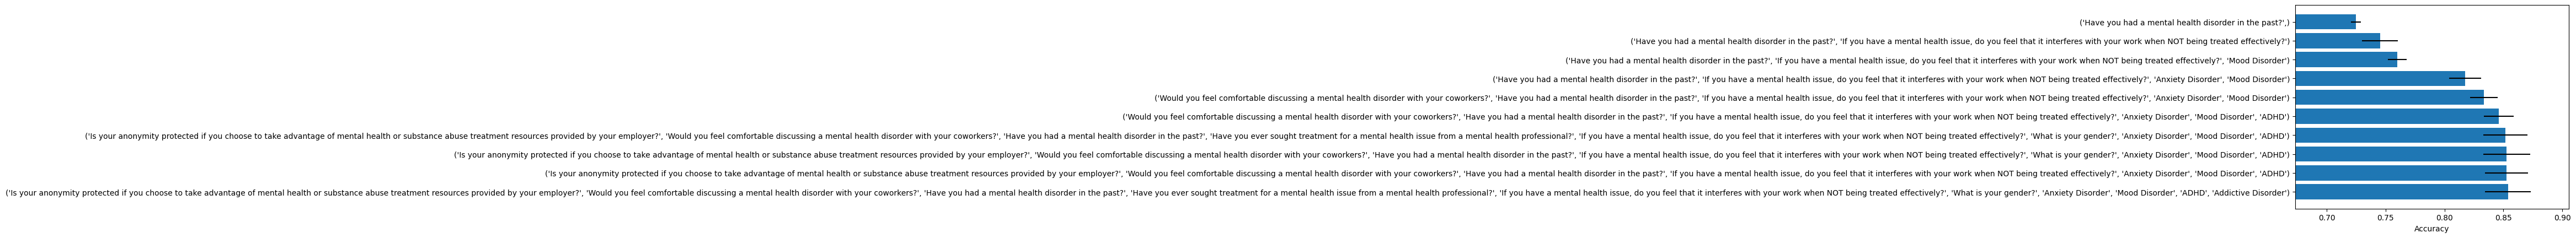

In [40]:
# create figure and axes
fig, ax = plt.subplots()
# plot bars
y_pos = np.arange(len(sfs_results))
ax.barh(y_pos, sfs_results['avg_score'], \
  xerr=sfs_results['std_err'])
# set axis ticks and labels
ax.set_yticks(y_pos)
ax.set_yticklabels(sfs_results['feature_names'])
ax.set_xlabel('Accuracy')
# limit range to overimpose differences
avg_scores = sfs_results['avg_score']
avg_score_min = min(avg_scores)
avg_score_max = max(avg_scores)
avg_score_diff = avg_score_max - avg_score_min
avg_score_visual_step = avg_score_diff * 0.4
plt.xlim([
    avg_score_min-avg_score_visual_step,
    avg_score_max+avg_score_visual_step
])

In [36]:
sfs_results

feature_idx  \
10  (5, 9, 33, 35, 37, 39, 46, 47, 48, 58)   
7               (5, 9, 33, 37, 46, 47, 48)   
8           (5, 9, 33, 37, 39, 46, 47, 48)   
9       (5, 9, 33, 35, 37, 39, 46, 47, 48)   
6                  (9, 33, 37, 46, 47, 48)   
5                      (9, 33, 37, 46, 47)   
4                         (33, 37, 46, 47)   
3                             (33, 37, 47)   
2                                 (33, 37)   
1                                    (33,)   

                                            cv_scores avg_score  \
10  [0.903954802259887, 0.8870056497175142, 0.7966...  0.853878   
7   [0.8983050847457628, 0.8870056497175142, 0.796...  0.852748   
8   [0.903954802259887, 0.8926553672316384, 0.7966...  0.852735   
9   [0.8983050847457628, 0.8870056497175142, 0.796...  0.851611   
6   [0.864406779661017, 0.8757062146892656, 0.8022...  0.845975   
5   [0.8531073446327684, 0.864406779661017, 0.7966...  0.833507   
4   [0.8361581920903954, 0.847457627118644, 0.7683...  0.817668   
3   [0.7627118644067796, 0.7796610169491526, 0.740...  0.759906   
2   [0.7401129943502824, 0.8022598870056498, 0.711...  0.745166   
1   [0.7231638418079096, 0.7344632768361582, 0.711...  0.724807   

                                        feature_names  ci_bound   std_dev  \
10  (Is your anonymity protected if you choose to ...  0.049711  0.038677   
7   (Is your anonymity protected if you choose to ...  0.047208   0.03673   
8   (Is your anonymity protected if you choose to ...  0.051348   0.03995   
9   (Is your anonymity protected if you choose to ...  0.047989  0.037337   
6   (Would you feel comfortable discussing a menta...  0.032315  0.025143   
5   (Would you feel comfortable discussing a menta...  0.030465  0.023702   
4   (Have you had a mental health disorder in the ...  0.034779  0.027059   
3   (Have you had a mental health disorder in the ...  0.019889  0.015474   
2   (Have you had a mental health disorder in the ...  0.038925  0.030285   
1   (Have you had a mental health disorder in the ...  0.010602  0.008248   

     std_err  
10  0.019338  
7   0.018365  
8   0.019975  
9   0.018669  
6   0.012571  
5   0.011851  
4    0.01353  
3   0.007737  
2   0.015143  
1   0.004124

In [34]:
sfs_results['avg_score']

10    0.853878
7     0.852748
8     0.852735
9     0.851611
6     0.845975
5     0.833507
4     0.817668
3     0.759906
2     0.745166
1     0.724807
Name: avg_score, dtype: object

In [35]:
sfs_results['feature_names']

10    (Is your anonymity protected if you choose to ...
7     (Is your anonymity protected if you choose to ...
8     (Is your anonymity protected if you choose to ...
9     (Is your anonymity protected if you choose to ...
6     (Would you feel comfortable discussing a menta...
5     (Would you feel comfortable discussing a menta...
4     (Have you had a mental health disorder in the ...
3     (Have you had a mental health disorder in the ...
2     (Have you had a mental health disorder in the ...
1     (Have you had a mental health disorder in the ...
Name: feature_names, dtype: object

In [37]:
min(sfs_results['avg_score'])

0.7248073959938367